**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Prepare the data](#toc2_)    
- 3. [Model](#toc3_)    
- 4. [Training & Evaluation](#toc4_)    
- 5. [Driver Code](#toc5_)    
  - 5.1. [Standalone](#toc5_1_)    
  - 5.2. [Hyperparameter Tuning](#toc5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Setup](#toc0_)

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from pprint import pprint
import yfinance as yf
import datetime as dt
import shap

# 2. <a id='toc2_'></a>[Prepare the data](#toc0_)

In [7]:
def prepare_data_multivariate(df, choosen_stock, features, look_back, train_days=-1, predict_type='year'):
    # Choose specific stock
    data = df[df["Stock"] == choosen_stock]

    # Testing split
    if predict_type=='year':
        test_data = data[data["Date"].dt.year == 2019]
    elif predict_type=='month':
        test_data = data[(data["Date"].dt.year == 2019) & (data["Date"].dt.month.isin([1]))]
    else:
        test_data = data[data["Date"].dt.year == 2019][0:20] 
        # test_data = data[(data["Date"] >= "2019-01-01") & (data["Date"] <= "2019-01-16")]
    
    if(train_days==-1):
        # Training split: data for years 2015-2018
        train_data = data[data["Date"].dt.year.isin(range(2015, 2019))]
        valid_size = int(len(data) * 0.10)
        train_data, valid_data = train_data[:-valid_size], train_data[-valid_size:]
    else:
        # Extract the date range for training data based on the test data
        train_end_date = test_data["Date"].min() - pd.DateOffset(days=1)
        train_start_date = train_end_date - pd.DateOffset(days=train_days)
        train_data = data[(data["Date"] >= train_start_date) & (data["Date"] <= train_end_date)]
        valid_size = int(len(data) * 0.02)
        train_data, valid_data = train_data[:-valid_size], train_data[-valid_size:]
    
    # Feature selection and engineering
    train_data = train_data[features + ["Date"]].values
    valid_data = valid_data[features + ["Date"]].values
    test_data = test_data[features + ["Date"]].values
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data[:, :-1] = scaler.fit_transform(train_data[:, :-1])
    valid_data[:, :-1] = scaler.transform(valid_data[:, :-1])
    test_data[:, :-1] = scaler.transform(test_data[:, :-1])
    
    # Create sequences for LSTM input
    def create_sequences(dataset, look_back=1):
        X, Y, dates = [], [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back), :-1])
            Y.append(dataset[i + look_back, 0])
            dates.append(dataset[i + look_back, -1])  # Assuming the last column is 'Date'
        return np.array(X), np.array(Y), np.array(dates)

    train_X, train_Y, train_dates = create_sequences(train_data, look_back)
    valid_X, valid_Y, valid_dates = create_sequences(valid_data, look_back)
    test_X, test_Y, test_dates = create_sequences(test_data, look_back)

    # Convert data to PyTorch tensors
    train_X = torch.Tensor(train_X.astype(np.float32))
    train_Y = torch.Tensor(train_Y)
    valid_X = torch.Tensor(valid_X.astype(np.float32))
    valid_Y = torch.Tensor(valid_Y)
    test_X = torch.Tensor(test_X.astype(np.float32))
    test_Y = torch.Tensor(test_Y)
    
    return train_X, train_Y, train_dates, valid_X, valid_Y, valid_dates, test_X, test_Y, test_dates, scaler

# 3. <a id='toc3_'></a>[Model](#toc0_)

In [8]:
class MultivariateLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultivariateLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 4. <a id='toc4_'></a>[Training & Evaluation](#toc0_)

In [9]:
def train_evaluate_lstm_multivariate(input_size, hidden_sizes, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler, visualize=False):
    # Initialize the model
    model = MultivariateLSTMModel(input_size, hidden_sizes, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    # Training the model
    train_losses = []
    val_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        outputs = model(train_X)
        optimizer.zero_grad()
        loss = criterion(outputs.view(-1), train_Y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        model.eval()
        val_outputs = model(valid_X)
        val_loss = criterion(val_outputs.view(-1), valid_Y)
        val_losses.append(val_loss.item())
        
        if visualize == True:
            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
    
    model.eval()
    
    # Calculate predictions
    train_predict = model(train_X).view(-1).cpu().detach().numpy()
    valid_predict = model(valid_X).view(-1).cpu().detach().numpy()
    test_predict = model(test_X).view(-1).cpu().detach().numpy()
    
    # Compute MAPE
    train_mape = mean_absolute_percentage_error(train_Y, train_predict)
    valid_mape = mean_absolute_percentage_error(valid_Y, valid_predict)
    test_mape = mean_absolute_percentage_error(test_Y, test_predict)

    # Evaluate the model using metrics like mean squared error (MSE)
    train_rmse = mean_squared_error(train_Y, train_predict, squared=False)
    valid_rmse = mean_squared_error(valid_Y, valid_predict, squared=False)
    test_rmse = mean_squared_error(test_Y, test_predict, squared=False)
    
    if visualize == True:
        
        # 1. Visualize training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss', linewidth=2)
        plt.plot(val_losses, label='Validation Loss', linewidth=2)
        plt.title("Training and Validation Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

        # 2. Visualize test and predictions
        plt.figure(figsize=(10, 5))
        plt.plot(test_dates, test_Y, label='True', linewidth=2)
        plt.plot(test_dates, test_predict, label='Predicted', linewidth=2)
        plt.title("Test vs. Predicted Prices")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
    
    return model, loss, train_rmse, valid_rmse, test_rmse, train_mape, valid_mape, test_mape

# 5. <a id='toc5_'></a>[Driver Code](#toc0_)

## 5.1. <a id='toc5_1_'></a>[Standalone](#toc0_)

[*********************100%%**********************]  5 of 5 completed
Epoch [20/100], Training Loss: 0.0157, Validation Loss: 0.0620
Epoch [40/100], Training Loss: 0.0007, Validation Loss: 0.0037
Epoch [60/100], Training Loss: 0.0007, Validation Loss: 0.0021
Epoch [80/100], Training Loss: 0.0006, Validation Loss: 0.0028
Epoch [100/100], Training Loss: 0.0005, Validation Loss: 0.0026


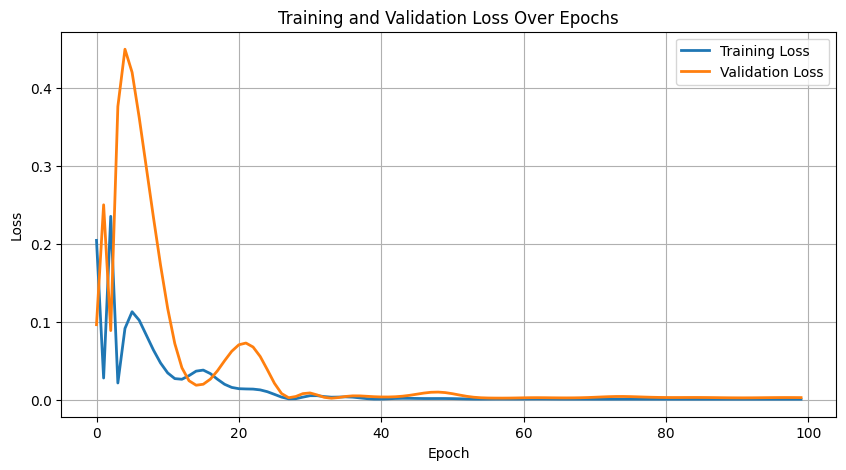

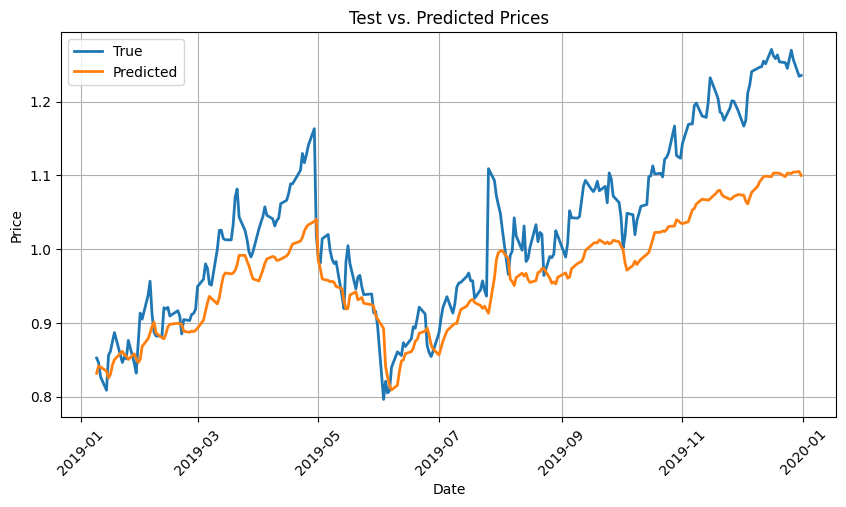

MultivariateLSTMModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
test_rmse:  0.08
test_mape:  0.06


In [10]:
# Load the data
yf.pdr_override() # Override pandas datareader with yfinance
y_symbols = ['AAPL', 'GOOG', 'AMZN', 'TSLA', 'MSFT'] # list of stock symbols
startdate = dt.datetime(2015, 1, 1) # start date
enddate = dt.datetime(2020, 12, 31) # end date
df = yf.download(y_symbols, start=startdate, end=enddate) # Retrieve historical stock price data for the specified symbols and date range
df = df.stack(level=1) # Stack the multi-level index to create a single-level index
df = df.reset_index() # Reset the index to make 'Date' a regular column
df.columns = ['Date', 'Stock', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] # Rename the columns to match the desired structure
df['Date'] = pd.to_datetime(df['Date'])

# choose stock and lags
choosen_stock = "GOOG"
look_back = 5
train_days = -1
predict_type = 'year'

train_X, train_Y, train_dates, valid_X, valid_Y, valid_dates, test_X, test_Y, test_dates, scaler  = prepare_data_multivariate(df, choosen_stock, features=['Close', 'High', 'Low', 'Open', 'Volume'], look_back=look_back, train_days=train_days, predict_type=predict_type)

# Define hyperparameters
input_size = 5  # Number of input features (High, Low, Open, Close, Volume)
hidden_sizes = 64  # Number of hidden units in the LSTM
num_layers = 1  # Number of LSTM layers
output_size = 1  # Number of output features (Close price)
learning_rate = 0.02
num_epochs = 100

# Create the model
model, loss, train_rmse, valid_rmse, test_rmse, train_mape, valid_mape, test_mape = train_evaluate_lstm_multivariate(input_size, hidden_sizes, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler, visualize=True)

print(model)
print("test_rmse: ", round(test_rmse, 2))
print("test_mape: ", round(test_mape, 2))

Next 1 Year:

1. train_days=60:
    - test_rmse:  1.99
    - test_mape:  1.22

2. train_days=100:
    - test_rmse:  0.12
    - test_mape:  0.14

3. train_days=365:
    - test_rmse:  0.07
    - test_mape:  0.09

4. train_days=730:
    - test_rmse:  0.04
    - test_mape:  0.04

5. 4 years:
    - test_rmse:  0.08
    - test_mape:  0.06

**Observations:**

- Training and Validation loss decreases over the epochs.

- Predictions are more accurate for shorter timeframes with more accuracy in predicting immediately following dates.

unrecognized nn.Module: LSTM


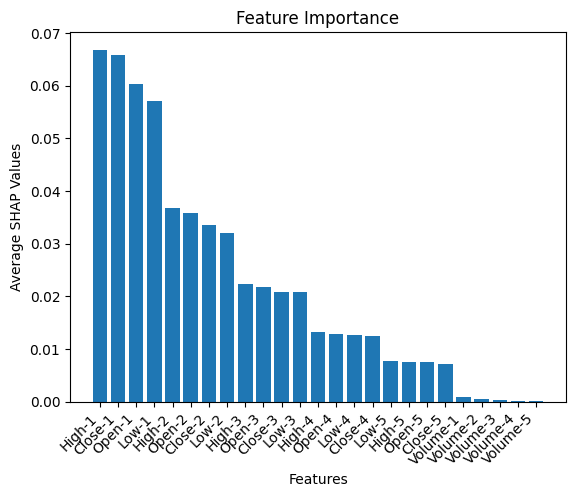

In [11]:
# Feature importances
explainer = shap.DeepExplainer(model, train_X)
shap_values = explainer.shap_values(test_X, check_additivity=False)

# Extract feature names and create a dictionary
feature_names = ['Close', 'High', 'Low', 'Open', 'Volume']
lag_names = [f'{feature}-{i}' for i in range(look_back,0,-1) for feature in feature_names]
shap_dict = {}

k=0
for i in range(0,5):
    for j in range(0,5):
        shap_dict[lag_names[k]] = shap_values[:, i, j].mean()
        k = k+1

# Sort the dictionary by values
sorted_shap_dict = dict(sorted(shap_dict.items(), key=lambda item: item[1], reverse=True))

# Create a bar chart
plt.bar(sorted_shap_dict.keys(), sorted_shap_dict.values())
plt.xlabel('Features')
plt.ylabel('Average SHAP Values')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

## 5.2. <a id='toc5_2_'></a>[Hyperparameter Tuning](#toc0_)

In [45]:
## Tuning

# Load the data
yf.pdr_override() # Override pandas datareader with yfinance
y_symbols = ['AAPL', 'GOOG', 'AMZN', 'TSLA', 'MSFT']
startdate = dt.datetime(2015, 1, 1) # start date
enddate = dt.datetime(2020, 12, 31) # end date
df = yf.download(y_symbols, start=startdate, end=enddate) # Retrieve historical stock price data for the specified symbols and date range
df = df.stack(level=1) # Stack the multi-level index to create a single-level index
df = df.reset_index() # Reset the index to make 'Date' a regular column
df.columns = ['Date', 'Stock', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] # Rename the columns to match the desired structure
df['Date'] = pd.to_datetime(df['Date'])

# Hyperparameters
choosen_stock = "GOOG"  # [TSLA, GOOG, AAPL, MSFT, AMZN]
look_back_values = [5] 
hidden_size_values = [64, 128] 

num_layers_values = [1] # [2, 3, 4]
learning_rate_values = [0.005, 0.01, 0.02]  
num_epochs = 100
years_to_include = [2015, 2016, 2017, 2018, 2019]

train_days_values = [-1, 60, 100, 365, 365*2]
predict_type = 'year'

best_models = []
top_k = 3  # Get the top k performing models

# Hyperparameter tuning loop
for look_back in look_back_values:
    for hidden_size in hidden_size_values:
        for num_layers in num_layers_values:
            for learning_rate in learning_rate_values:
                 for train_days in train_days_values:
                    # print(f"\nHyperparameters: look_back={look_back}, hidden_size={hidden_size}, num_layers={num_layers}, learning_rate={learning_rate}")
                    # train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler = prepare_data_multivariate(df, choosen_stock, features=['High', 'Low', 'Open', 'Close', 'Volume'], look_back=10)
                    train_X, train_Y, train_dates, valid_X, valid_Y, valid_dates, test_X, test_Y, test_dates, scaler  = prepare_data_multivariate(df, choosen_stock, features=['Close', 'High', 'Low', 'Open', 'Volume'], look_back=look_back, train_days=train_days, predict_type=predict_type)
                    model, loss, train_rmse, valid_rmse, test_rmse, train_mape, valid_mape, test_mape = train_evaluate_lstm_multivariate(input_size, hidden_sizes, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler, visualize=False)
                    best_models.append({
                        "look_back": look_back,
                        "model" : model,
                        "learning_rate": learning_rate,
                        "train_days": train_days,
                        # "train_rmse": train_rmse,
                        # "valid_rmse": valid_rmse,
                        "test_rmse": test_rmse,
                        # "train_mape": train_mape,
                        # "valid_mape": valid_mape,
                        "test_mape": test_mape,
                    })

# Sort the models by RMSE in ascending order
best_models.sort(key=lambda x: (x["test_rmse"], x["test_mape"]))

# Print the top-k performing models
print(f"\nTop {top_k} Performing Models:")
pprint(best_models[:top_k])

[*********************100%%**********************]  5 of 5 completed

Top 3 Performing Models:
[{'learning_rate': 0.005,
  'look_back': 5,
  'model': MultivariateLSTMModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
),
  'test_mape': 0.033755757,
  'test_rmse': 0.0438587,
  'train_days': -1},
 {'learning_rate': 0.005,
  'look_back': 5,
  'model': MultivariateLSTMModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
),
  'test_mape': 0.035387356,
  'test_rmse': 0.04637497,
  'train_days': -1},
 {'learning_rate': 0.01,
  'look_back': 5,
  'model': MultivariateLSTMModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
),
  'test_mape': 0.044153344,
  'test_rmse': 0.04800548,
  'train_days': 730}]


**Observations:**

- Hyperparameter tuning results in top k models having almost similar performance.